<a href="https://colab.research.google.com/github/mudesir/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Build_Mudesir_Suleyman4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model Interpretation
## Assignment


In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

Saving hotel_reserve.zip to hotel_reserve.zip


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('hotel_reserve.zip')

data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# change resrvation_status date to date 
data['reservation_status_date'] = pd.to_datetime(data['reservation_status_date'])
data['reservation_status_date']

0        2015-07-01
1        2015-07-01
2        2015-07-02
3        2015-07-02
4        2015-07-03
            ...    
119385   2017-09-06
119386   2017-09-07
119387   2017-09-07
119388   2017-09-07
119389   2017-09-07
Name: reservation_status_date, Length: 119390, dtype: datetime64[ns]

In [54]:
# shape
data.shape

(119390, 32)

In [55]:
# Split data into train and test avoid leakage of information
# from test to train or from target to features and clean
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=42)
train.shape, test.shape


((95512, 32), (23878, 32))

In [56]:
# Split train into train and val
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=42)
train.shape, val.shape ,test.shape

((76409, 32), (19103, 32), (23878, 32))

In [57]:
def wrangle(X):
  X=X.copy()
  # drop with high cardinality and with high nan value
  X = X.drop(columns=['reservation_status', 'country', 'agent', 'company', 
                      'reservation_status', 'adr'])
  X = X.dropna()
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [58]:
# print shape
print('Train shape: ', train.shape)
print('Val shape: ', val.shape)
print('Test shape: ', test.shape)


Train shape:  (76405, 27)
Val shape:  (19103, 27)
Test shape:  (23878, 27)


In [59]:
# get target and features
target = 'is_canceled'
features = train.drop(columns=[target])
features = features.select_dtypes(include='number').columns.tolist()

In [60]:
features

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [61]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
!pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 2.3MB/s 


In [17]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
)
# fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8300266973773753


## Permutation and Boosting

In [18]:
# basline
y_train.value_counts(normalize=True) 

0    0.630194
1    0.369806
Name: is_canceled, dtype: float64

In [19]:
pipeline

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                      

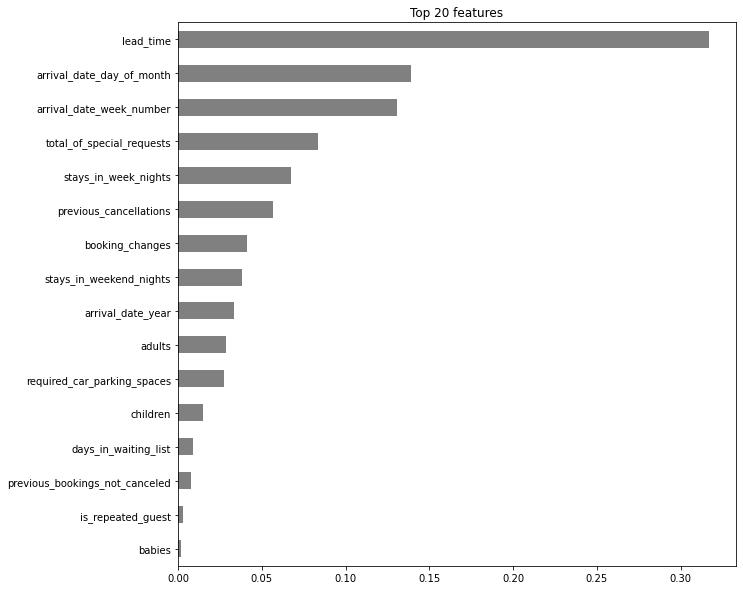

In [21]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [22]:
# The best in theory, but too slow in practice

column  = 'lead_time'

### Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

### Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

### Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without lead_time: 0.7809244621263676
Validation Accuracy with lead_time: 0.8305501753651259
Drop-Column Importance for lead_time: 0.04962571323875831


In [23]:
# Permutation Importance
feature = 'lead_time'
X_val[feature].value_counts()

0      1008
1       581
2       325
4       280
3       262
       ... 
354       1
608       1
460       1
517       1
345       1
Name: lead_time, Length: 452, dtype: int64

In [24]:
X_val[feature].head()

117752     13
23383       1
108866    194
98811     159
67456     214
Name: lead_time, dtype: int64

In [25]:
X_val_shuffled = X_val.copy()

In [26]:
X_val_shuffled[feature] = np.random.permutation(X_val[feature])

In [27]:
X_val_shuffled[feature].head()

117752     6
23383     80
108866    74
98811     19
67456     13
Name: lead_time, dtype: int64

In [28]:
score_with = pipeline.score(X_val, y_val)
score_permuted = pipeline.score(X_val_shuffled, y_val)

print(f'Validation Accuracy with {feature}: {score_with}')
print(f'Validation Accuracy with {feature} permuted: {score_permuted}')
print(f'Permutation Importance: {score_with - score_permuted}')

Validation Accuracy with lead_time: 0.8305501753651259
Validation Accuracy with lead_time permuted: 0.7147568444746898
Permutation Importance: 0.11579333089043609


In [29]:
from sklearn.inspection import permutation_importance

In [30]:
## With eli5 
# eli5 doesn't work with pipelines
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
!pip install --upgrade category_encoders
!pip install category_encoders==2.*
!pip install eli5

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)
     |████████████████████████████████| 112kB 2.8MB/s 


In [33]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [34]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

Weight,Feature
0.1140 ± 0.0048,lead_time
0.0982 ± 0.0032,total_of_special_requests
0.0603 ± 0.0040,arrival_date_year
0.0551 ± 0.0017,previous_cancellations
0.0540 ± 0.0035,arrival_date_week_number
0.0440 ± 0.0055,stays_in_week_nights
0.0315 ± 0.0026,stays_in_weekend_nights
0.0309 ± 0.0024,booking_changes
0.0294 ± 0.0020,arrival_date_day_of_month
0.0190 ± 0.0012,adults


In [62]:
# We can use importances for feature selection
print('Shape before removing features', X_train.shape)

Shape before removing features (76405, 16)


In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    #SimpleImputer(strategy='median'), 
    GradientBoostingClassifier()
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_we

In [66]:
print('Training Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Training Accuracy: 0.7636149466657941
Validation Accuracy: 0.7680469036277024


In [42]:
from xgboost import XGBClassifier

In [67]:
# XGBoost parameters tuning
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='error', 
          early_stopping_rounds=10) # Stop if the score hasn't improved in 50 rounds

[0]	validation_0-error:0.240626	validation_1-error:0.237031
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.238008	validation_1-error:0.234413
[2]	validation_0-error:0.235299	validation_1-error:0.231011
[3]	validation_0-error:0.234579	validation_1-error:0.230173
[4]	validation_0-error:0.233427	validation_1-error:0.229754
[5]	validation_0-error:0.232668	validation_1-error:0.22944
[6]	validation_0-error:0.232184	validation_1-error:0.228655
[7]	validation_0-error:0.231045	validation_1-error:0.227713
[8]	validation_0-error:0.228532	validation_1-error:0.226509
[9]	validation_0-error:0.226464	validation_1-error:0.224415
[10]	validation_0-error:0.22509	validation_1-error:0.224153
[11]	validation_0-error:0.219802	validation_1-error:0.219913
[12]	validation_0-error:0.217486	validation_1-error:0.218552
[13]	validation_0-error:0.21619	validation_1-error:0.21708

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

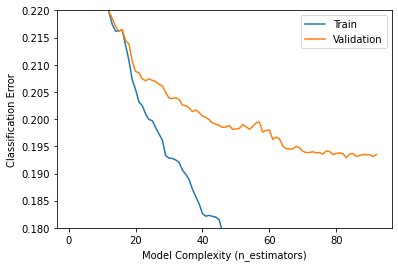

In [45]:
# plot
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [47]:
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 57.7MB 70kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=24656cd19a264565b0dae61347214872a35f40ef113e15a01b0e7df2de4404db
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394110 sha256=47c5425b014ddc64894acdfacea092574973e74cb0245d566486fa66a83ec1c5
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


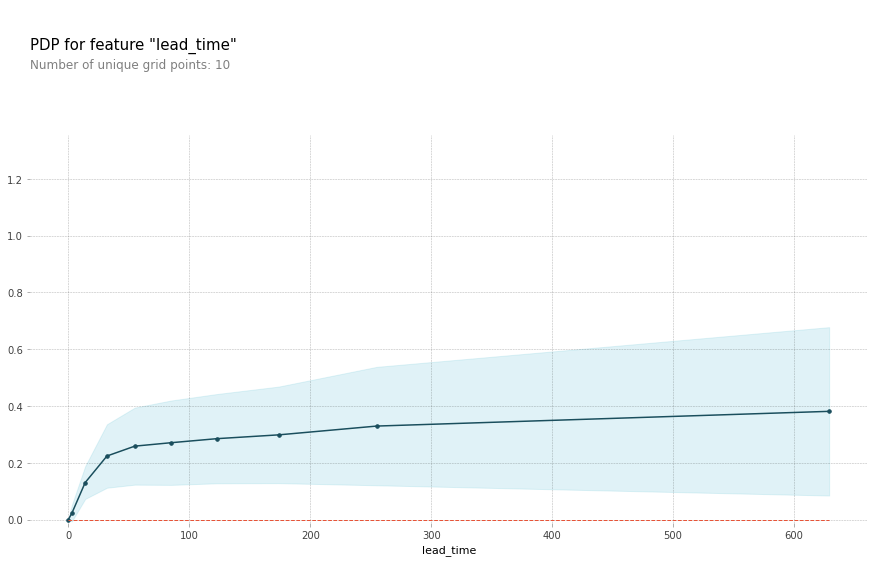

In [71]:
# pdp

%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature1 = 'lead_time'
pdp_dist = pdp.pdp_isolate(
    model=pipeline,
    dataset = X_val,
    model_features=features,
    feature=feature1
)
pdp.pdp_plot(pdp_dist, feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


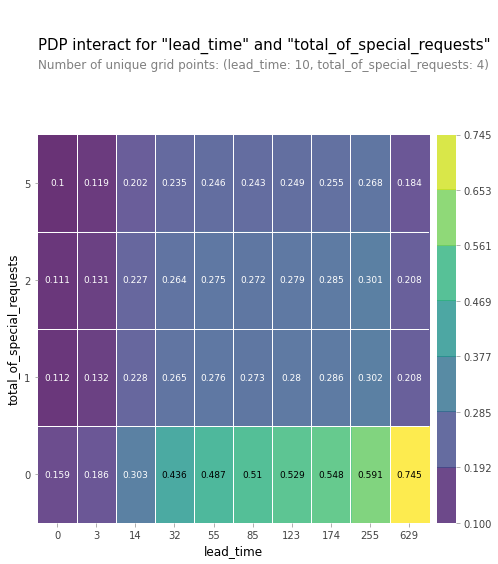

In [76]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features2 = ['lead_time', 'total_of_special_requests']

interact = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features2,
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features2);

In [ ]:
#SHAP
